## CE-like background: first pass

A minimal analysis with a few files before scaling up. 

Dataset: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root`

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

A bit awkard but I'm using my dev version of pyutils 

In [1]:
import sys
sys.path.append("../../EventNtuple/utils/pyutils")
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from pyprocess import Processor
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector

# Import data

In [2]:
processor = Processor( 
    use_remote = True,
    location = "disk",
    verbosity = 1
)

branches = { 
    "evt" : [
        "run",
        "subrun",
        "event",
    ],
    "crv" : [
        "crvcoincs.time",
        "crvcoincs.nHits"
    ],
    "trk" : [
        "trk.nactive", 
        "trk.pdg", 
        "trkqual.valid",
        "trkqual.result"
    ],
    "trkfit" : [
        "trksegs",
        "trksegpars_lh"
    ],
    "trkmc" : [
        "trkmcsim"
    ]
}


# Possible on-spill dataset 
# nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root

# Single file
# data = importer.import_file(
#     file_name = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root",
#     # branches = "*"
#     branches = branches
# )

# First 25 files
data = processor.process_data(
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt",
    branches = branches,
    max_workers = 100
)

[pyutils] Setting environment variables for this process...
[pyutils] ✅ Environment variables set
[pyprocess] ✅ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] ✅ Successfully loaded file list
	Path: /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt
	Count: 100 files
[pyprocess] Starting processing on 100 files with 100 workers


Processing: 100%|██████████████████████████████| 100/100 [02:00<00:00,  1.21s/file, succesful=100, f


[pyprocess] ✅ Returning concatenated array containing 705770 events


In [3]:
# mask = data["trkfit"]["trkmcsim"]["pdg"] == 11 
# # # print(mask)
# # print(data)
# # printer = Print()
# printer.print_n_events(data, n_events=1)

In [3]:
# data.type.show()

## Cuts

* All track parents are electrons 
* Downstream tracks only (p_z > 0 through tracker)
* Minimum active hits in the tracker (nactive >= 20)
* t0 at tracker entrance (640 < t_0 < 1650 ns)
* track quality (quality > 0.8) 
* Loop helix maximum radius (450 < R_max < 650 mm)
* Extrapolated position at ST (|d_0| < 100 mm)
* Extrapolated pitch angle at ST (0.5577350 < tan(theta) < 1.0) 

## Cut manager

Keep track of cuts and the fraction of data that each cut removes. 

Need to get this working with multiprocessing. It needs to create a cut object that tracks the events passing each cut and then sums them up. 

We can't store the masks for each file. 



In [22]:
# from cut_manager import CutManager

import json
import awkward as ak

# Can move this into pyselect
class CutManager:
    """Class to manage analysis cuts"""
    
    def __init__(self, verbosity=1):
        """Initialise 
        
        Args:
            verbosity (int, optional): Printout level (0: minimal, 1: normal, 2: detailed)
        """

        # Initilaise parameters
        self.verbosity = verbosity
        self.print_prefix = "[pyselect] "
        
        # Initialise cut container
        self.cuts = {}
    
    def add_cut(self, name, description, mask, active=True):
        """
        Add a cut to the collection.
        
        Args: 
            name (str): Name of the cut
            description (str): Description of what the cut does
            mask (awkward.Array): Boolean mask array for the cut
            active (bool, optional): Whether the cut is active by default
        """

        # Get the next available index
        next_idx = len(self.cuts)
    
        self.cuts[name] = {
            "description": description,
            "mask": mask,
            "active": active,
            "idx" : next_idx
        }

        if self.verbosity >= 2:
            print(f"{self.print_prefix}Added cut {name} with index {next_idx}")
        # return self
        # This would allow method chaining, could be useful maybe?
    
    def get_cut_mask(self, name):
        """Utility to return the Boolean mask for a specific cut.
        
        Args:
            name (str): Name of the cut
            
        """
        if name in self.cuts:
            return self.cuts[name]["mask"]
        else:
            raise ValueError(f"{self.print_prefix}Cut '{name}' not defined")
    
    def set_active_cut(self, name, active=True):
        """Utility to set a cut as active or inactive 

        Args: 
            name (str): Name of the cut
            active (bool, optional): Whether the cut should be active. Default is True.
        """
        if name in self.cuts:
            self.cuts[name]["active"] = active
        else:
            raise ValueError(f"{self.print_prefix}Cut '{name}' not defined")
            
    def get_active_cuts(self):
        """Utility to get all active cutss"""
        return {name: cut for name, cut in self.cuts.items() if cut["active"]}
    
    def combine_cuts(self, cut_names=None, active_only=True):
        """ Return a Boolean combined mask from specified cuts. Applies an AND operation across all cuts. 
        Args: 

        cut_names (list, optional): List of cut names to include (if None, use all cuts)
        active_only (bool, optional): Whether to only include active cuts
        """
        if cut_names is None:
            # Then use all cuts in original order
            cut_names = list(self.cuts.keys())
        # Init mask
        combined = None
        # Loop through cuts        
        for name in cut_names:
            # Get info dict for this cut
            cut_info = self.cuts[name]
            # Active cuts
            if active_only and not cut_info["active"]:
                continue
            # If first cut, initialise 
            if combined is None:
                combined = cut_info["mask"]
            else:
                combined = combined & cut_info["mask"] 
        
        return combined
    
    def calculate_cut_stats(self, data, progressive=True, active_only=False):
        """ Utility to calculate stats for each cut.
        
        Args:
            data (awkward.Array): Input data 
            progressive (bool, optional): If True, apply cuts progressively; if False, apply each cut independently. Default is True.
        """
        total_events = len(data)
        stats = []
        
        # Base statistics (no cuts)
        stats.append({
            "name": "No cuts",
            "active": "N/A",
            "description": "No selection applied",
            "events_passing": total_events,
            "absolute_frac": 100.0,
            "relative_frac": 100.0
        })
        
        # Get cuts 
        cuts = [name for name in self.cuts.keys()] 
        if active_only: 
            cuts = [name for name in self.cuts.keys() if self.cuts[name]["active"]]
        
        previous_mask = None
        
        for name in cuts:
            cut_info = self.cuts[name]
            mask = cut_info["mask"]
            
            if progressive and previous_mask is not None:
                # Apply this cut on top of previous cuts
                current_mask = previous_mask & mask
            else:
                # Apply this cut independently
                current_mask = mask
            
            # Calculate event-level efficiency
            event_mask = ak.any(current_mask, axis=-1) # events that have ANY True combined mask
            events_passing = ak.sum(event_mask) # Count up these events
            absolute_frac = events_passing / total_events * 100
            relative_frac = (events_passing / stats[-1]["events_passing"] * 100 
                           if stats[-1]["events_passing"] > 0 else 0)
            
            stats.append({
                "name": name,
                "active": cut_info["active"],
                "description": cut_info["description"],
                "mask": current_mask,
                "events_passing": int(events_passing),
                "absolute_frac": float(absolute_frac),
                "relative_frac": float(relative_frac)
            })
            
            if progressive:
                # Update for next iteration
                previous_mask = current_mask
        
        return stats
    
    def print_cut_stats(self, data, progressive=True, active_only=False):
        """ Print cut statistics for each cut.
        
        Args:
            data (awkward.Array): Data array
            progressive (bool, optional): If True, apply cuts progressively; if False, apply each cut independently
        """
        stats = self.calculate_cut_stats(data, progressive, active_only)
        
        # Print header
        print(f"\n{self.print_prefix}Cut Info:")
        print("-" * 110)
        header = "{:<20} {:<10} {:<20} {:<20} {:<20} {:<30}".format(
            "Cut", "Active", "Events Passing", "Absolute Frac. [%]", "Relative Frac. [%]", "Description")
        print(header)
        print("-" * 110)
        
        # Print each cut's statistics
        for stat in stats:
            row = "{:<20} {:<10} {:<20} {:<20.2f} {:<20.2f} {:<30}".format(
                stat["name"], 
                stat["active"],
                stat["events_passing"], 
                stat["absolute_frac"], 
                stat["relative_frac"], 
                stat["description"])
            print(row)
            
        print("-" * 110)
        
        # Print final statistics
        if len(stats) > 1:
            first_events = stats[0]["events_passing"]
            last_events = stats[-1]["events_passing"]
            overall_eff = last_events / first_events * 100 if first_events > 0 else 0
            
            print(f"{self.print_prefix}Summary: {last_events}/{first_events} events remaining ({overall_eff:.2f}%)")
    
    def save_cuts(self, file_name):
        """ Save the current cut configuration to a JSON file.
        
        Args:
            file_name (str): File path to save the configuration
        """
        config = {
            "cuts": {}
        }
        
        for name, info in self.cuts.items():
            config["cuts"][name] = {
                "description": info["description"],
                "active": info["active"],
                "idx": info["idx"]
            }
        
        with open(file_name, 'w') as f:
            json.dump(config, f, indent=2)
            
        if self.verbosity >= 1:
            print(f"{self.print_prefix}Saved cut configuration to {file_name}")


## Define cuts

In [26]:
cut_manager = CutManager(
    verbosity = 2
)

selector = Select(
    verbosity = 2
)

# Get cuts object
cuts = cut_manager.cuts

def define_cuts(data, on_spill=False):
    """ Returns a dict of defined cuts."""

    # Tracker surfaces
    trk_front = selector.select_surface(data["trkfit"], sid=0)
    trk_mid = selector.select_surface(data["trkfit"], sid=1)
    trk_back = selector.select_surface(data["trkfit"], sid=2)
    in_trk = (trk_front | trk_mid | trk_back)
    data["in_trk"] = trk_front # useful for plotting
    data["at_trk_front"] = trk_front # useful for plotting

    # 1. Truth track parent is electron 
    is_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
    is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
    is_trk_parent_electron = is_electron & is_trk_parent 
    has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) # Any tracks with electron parents?

    
    # trkmcsim-level definition, useful for plotting
    data["is_trk_parent"] = is_trk_parent
    data["is_trk_parent_electron"] = is_trk_parent_electron 
    data["is_electron"] = has_trk_parent_electron 

    # 1.5 Also include trk.pdg == 11
    is_trk_electron = selector.is_electron(data["trk"])

    # combined_is_electron_mask = is_trk_electron & has_trk_parent_electron
    
    # trk-level definition (the actual cut)
    # cut_manager.add_cut(
    #     name="is_electron", # call it "is_electron" for brevity
    #     description="Track parents are electrons (truth PID)", 
    #     mask=combined_is_electron_mask # has_trk_parent_electron
    # )

    cut_manager.add_cut(
        name="is_truth_electron", # call it "is_electron" for brevity
        description="Track parents are electrons (truth PID)", 
        mask=has_trk_parent_electron # has_trk_parent_electron
    )

    cut_manager.add_cut(
        name="is_reco_electron", # call it "is_electron" for brevity
        description="Tracks are assumed to be electrons (trk)", 
        mask=is_trk_electron # has_trk_parent_electron
    )
    
    # 2. Downstream tracks only through tracker
    is_downstream = selector.is_downstream(data["trkfit"])

     # trkseg-level definition, useful for plotting
    data["is_downstream_in_trk"] = is_downstream & trk_front 

    # trk-level definition (the actual cut)
    is_downstream = ak.all(~in_trk | is_downstream, axis=-1)
    cut_manager.add_cut(
        name="is_downstream",
        description="Downstream tracks only (p_z > 0 through tracker)",
        mask=is_downstream
    )
    
    # 3. Minimum hits
    has_hits = selector.has_n_hits(data["trk"], nhits=20)
    cut_manager.add_cut(
        name="has_hits",
        description="Minimum of 20 active hits in the tracker",
        mask=has_hits
    )

    if on_spill:
        # 4. Time at tracker entrance (trk level)
        within_t0 = ((640 < data["trkfit"]["trksegs"]["time"]) & 
                     (data["trkfit"]["trksegs"]["time"] < 1650))
        
        # trkseg-level definition, useful for plotting
        data["within_t0_at_trkent"] = within_t0 & trk_front 
    
        # trk-level definition (the actual cut)
        within_t0 = ak.all(~trk_front | within_t0, axis=-1)
        cut_manager.add_cut( # trk-level
            name="within_t0",
            description="t0 at tracker entrance (640 < t_0 < 1650 ns)",
            mask=within_t0
        )
        
    # 5. Track quality
    good_trkqual = selector.select_trkqual(data["trk"], quality=0.8)
    cut_manager.add_cut(
        name="good_trkqual",
        description="Track quality (quality > 0.8)",
        mask=good_trkqual
    )
    
    # 6. Loop helix maximum radius
    within_lhr_max = ((450 < data["trkfit"]["trksegpars_lh"]["maxr"]) & 
                      (data["trkfit"]["trksegpars_lh"]["maxr"] < 680)) # changed from 650

    # trkseg-level definition, useful for plotting
    data["within_lhr_max_at_trkent"] = within_lhr_max & trk_front # trkseg level, useful for plotting

    # trk-level definition (the actual cut)
    within_lhr_max = ak.all(~trk_front | within_lhr_max, axis=-1)
    cut_manager.add_cut(
        name="within_lhr_max",
        description="Loop helix maximum radius (450 < R_max < 680 mm)",
        mask=within_lhr_max
    )

    
    # 7. Distance from origin
    within_d0 = (data["trkfit"]["trksegpars_lh"]["d0"] < 100)

    # trkseg-level definition, useful for plotting
    data["within_d0_at_trkent"] = within_d0 & trk_front # trkseg level, useful for plotting

    # trk-level definition (the actual cut)
    within_d0 = ak.all(~trk_front | within_d0, axis=-1) 
    cut_manager.add_cut(
        name="within_d0",
        description="Extrapolated position (d_0 < 100 mm)",
        mask=within_d0
    )
    
    # 8. Pitch angle
    within_pitch_angle = ((0.5577350 < data["trkfit"]["trksegpars_lh"]["tanDip"]) & 
                          (data["trkfit"]["trksegpars_lh"]["tanDip"] < 1.0))


    # trkseg-level definition, useful for plotting
    data["within_pitch_angle_at_trkent"] = within_pitch_angle & trk_front 

    # trk-level definition (the actual cut) 
    within_pitch_angle = ak.all(~trk_front | within_pitch_angle, axis=-1)
    cut_manager.add_cut(
        name="within_pitch_angle",
        description="Extrapolated pitch angle (0.5577350 < tan(theta_Dip) < 1.0)",
        mask=within_pitch_angle
    )

    # 9. CRV veto: |dt| < 150 ns (dt = coinc time - track t0) 
    dt_threshold = 150  

    # Get min and max track t0 times for each event
    min_trk_time = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
    max_trk_time = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)

    # Get min and max coincidence times for each event
    min_coinc_time = ak.min(data["crv"]["crvcoincs.time"], axis=-1)
    max_coinc_time = ak.max(data["crv"]["crvcoincs.time"], axis=-1)

    # Broadcast coincidence times to match track times structure
    # This requires creating a cartesian product between coinc times and track times
    # We'll use the ak.cartesian function to do this
    
    # First, create arrays with the right structure
    coinc_info = ak.zip({
        "min_time": min_coinc_time,
        "max_time": max_coinc_time
    })
    
    trk_info = ak.zip({
        "min_time": min_trk_time,
        "max_time": max_trk_time
    })
    
    # Use cartesian product to align each coinc with each track
    matched = ak.cartesian({"coinc": coinc_info, "track": trk_info})
    
    # Check if the ranges overlap or are within threshold
    # Two ranges [a,b] and [c,d] are close if:
    # (c - time_threshold <= b) and (a <= d + time_threshold)
    
    # veto = (
    #     (matched["coinc", "max_time"] + dt_threshold >= matched["track", "min_time"]) & 
    #     (matched["track", "max_time"] + dt_threshold >= matched["coinc", "min_time"])
    # )

    veto = (
        (abs(matched["coinc", "min_time"] - matched["track", "max_time"]) < dt_threshold) & 
        (abs(matched["track", "min_time"] - matched["coinc", "max_time"]) < dt_threshold)
    )

    data["unvetoed"] = ~veto
    
    cut_manager.add_cut(
        name="unvetoed",
        description="No veto: |dt| >= 150 ns",
        mask=~veto,
        active=False
    )
    
define_cuts(data, on_spill=False)
cut_manager.print_cut_stats(data, active_only=False)
cut_manager.save_cuts("../txt/cuts_0.json")

[pyselect] Initialised Select with verbosity = 2
[pyselect] Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] Returning mask for trksegs with sid = 1 and sindex = 0
[pyselect] Returning mask for trksegs with sid = 2 and sindex = 0
[pyselect] Returning mask for e- tracks
[pyselect] Added cut is_truth_electron with index 0
[pyselect] Added cut is_reco_electron with index 1
[pyselect] Returning mask for downstream track segments (p_z > 0)
[pyselect] Added cut is_downstream with index 2
[pyselect] Added cut has_hits with index 3
[pyselect] Returning mask for trkqual > 0.8
[pyselect] Added cut good_trkqual with index 4
[pyselect] Added cut within_lhr_max with index 5
[pyselect] Added cut within_d0 with index 6
[pyselect] Added cut within_pitch_angle with index 7
[pyselect] Added cut unvetoed with index 8

[pyselect] Cut Info:
--------------------------------------------------------------------------------------------------------------
Cut                  Active     Events P

In [7]:
# !cat ../txt/cuts_0.json

In [28]:
# trk_front = selector.select_surface(data["trkfit"], sid=0)

# # Get min and max track t0 times for each event
# min_trk_time = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
# max_trk_time = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)

# # Get min and max coincidence times for each event
# min_coinc_time = ak.min(data["crv"]["crvcoincs.time"], axis=-1)
# max_coinc_time = ak.max(data["crv"]["crvcoincs.time"], axis=-1)

# # Broadcast coincidence times to match track times structure
# # This requires creating a cartesian product between coinc times and track times
# # We'll use the ak.cartesian function to do this

# # First, create arrays with the right structure
# coinc_info = ak.zip({
#     "min_time": min_coinc_time,
#     "max_time": max_coinc_time
# })

# trk_info = ak.zip({
#     "min_time": min_trk_time,
#     "max_time": max_trk_time
# })

# # Use cartesian product to match each coinc with each track
# matched = ak.cartesian({"coinc": coinc_info, "track": trk_info})

# print(matched)

# printer.print_n_events(data)
# printer.print_n_events(matched)

print(cuts)

{'is_truth_electron': {'description': 'Track parents are electrons (truth PID)', 'mask': <Array [[False, False, False, False], ..., [...]] type='705770 * var * ?bool'>, 'active': True, 'idx': 0}, 'is_reco_electron': {'description': 'Tracks are assumed to be electrons (trk)', 'mask': <Array [[False, True, False, False], ..., [...]] type='705770 * var * bool'>, 'active': True, 'idx': 1}, 'is_downstream': {'description': 'Downstream tracks only (p_z > 0 through tracker)', 'mask': <Array [[True, False, True, False], ..., [...]] type='705770 * var * bool'>, 'active': True, 'idx': 2}, 'has_hits': {'description': 'Minimum of 20 active hits in the tracker', 'mask': <Array [[True, True, True, True], ..., [True, ...]] type='705770 * var * bool'>, 'active': True, 'idx': 3}, 'good_trkqual': {'description': 'Track quality (quality > 0.8)', 'mask': <Array [[False, False, False, False], ..., [...]] type='705770 * var * bool'>, 'active': True, 'idx': 4}, 'within_lhr_max': {'description': 'Loop helix m

## Apply cuts

In [36]:
# Make a copy
data_cut = ak.copy(data)

# Combine cuts
combined = cut_manager.combine_cuts(active_only=False) 
data_cut["combined"] = combined

# Print().print_n_events(data_cut)

# # Select tracks
data_cut["trk"] = data_cut["trk"][combined]
data_cut["trkfit"] = data_cut["trkfit"][combined]
data_cut["trkmc"] = data_cut["trkmc"][combined]

# print(combined)

# # # Then clean up events with no tracks after cuts
# # What about None? 
combined = ak.any(combined, axis=-1)


print(combined)
# # print(ak.sum(combined))
# # print(ak.any(combined))
# # print(ak.argmax(combined))
# # print(combined[ak.argmax(combined)])
# print(data[ak.argmax(combined)])
# # printer.print_n_events(data[0])
# # printer.print_n_events(data[ak.argmax(combined)])

# printer.print_n_events(data[data["evt"]["event"] == 283508])
# # test = combined[combined]
# # for i in test:
# #     print(i)

data_cut = data_cut[combined] 

# print(data_cut)

# print("data_cut structure")

# data_cut.type.show()

# print("combined cut structure")

# combined.type.show()
Print().print_n_events(data_cut)

# Print(verbose=True).print_n_events(data_cut)

[False, False, False, False, False, ..., False, False, False, False, False]
[pyprint] Initialised Print with verbose = False and precision = 1

[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 283508
evt.run: 1202
evt.subrun: 17940
crv.crvcoincs.time: [2.44e+04, 2.44e+04, 2.43e+04]
crv.crvcoincs.nHits: [16, 33, 13]
in_trk: [[False, False, False, False, False, ..., False, True, False, False], ...]
at_trk_front: [[False, False, False, False, False, ..., False, True, False, False], ...]
is_trk_parent: [[True, False, False], [True, False, False], [...], [True, False, False]]
is_trk_parent_electron: [[True, False, False], [True, False, False], [...], [True, False, False]]
is_electron: [True, True, True, True]
is_downstream_in_trk: [[False, False, False, False, False, ..., False, True, False, False], ...]
within_lhr_max_at_trkent: [[False, False, False, False, False, ..., False, True, False, False], ...]
w

## Inspect

In [33]:
print(len(CE_like))
# printer.print_n_events(data_cut)

1


In [97]:
# # has_coinc = abs(data_cut["crv"]["crvcoincs.time"] - data_cut["trkfit"]["trksegs"]["time"]) < 150
# # print(data["crv"]["crvcoincs.nHits"] > 0)
# # print(has_coinc)
# # has_coinc = ak.any(data["crv"]["crvcoincs.nHits"] > 0, axis=-1)
# # data["has_coinc"] = has_coinc
# # printer.print_n_events(data, n_events=4)

# # trk_front = selector.select_surface(data["trkfit"], sid=0)
# # coinc_time = data["crv"]["crvcoincs.time"] # , axis=-1)
# # max_trk_t0 = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
# # min_trk_t0 = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
# # # Maybe compare min and max? 

# # print(coinc_time)
# # print(max_trk_t0)
# # print(min_trk_t0)

# # coinc_time[0].type.show()
# # trk_t0[0].type.show()
# # # Are any of the coincidences close in time to any of the track t0s? 

# # Define your threshold for "close" in time units
# # time_threshold = 150  # adjust as needed

# # # Get min and max track t0 times for each event
# # min_trk_t0 = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
# # max_trk_t0 = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)

# # # Get min and max coincidence times for each event
# # min_coinc_time = ak.min(data["crv"]["crvcoincs.time"], axis=-1)
# # max_coinc_time = ak.max(data["crv"]["crvcoincs.time"], axis=-1)

# # min_trk_t0.type.show()
# # min_coinc_time.type.show()
# # Check if the ranges overlap or are within threshold
# # Two ranges [a,b] and [c,d] are close if:
# # (c - time_threshold <= b) and (a <= d + time_threshold)
# # c - b < time_threshold
# # a - d < time_threshold 
# # [min_trk_t0, max_trk_t0], [min_coinc_time, max_coinc_time]

# # veto = (
# #     (min_coinc_time - max_trk_t0 < time_threshold) & 
# #     (min_trk_t0 < max_coinc_time + time_threshold)
# # )

# # veto = (
# #     (abs(min_coinc_time - max_trk_t0) < time_threshold) & 
# #     (abs(min_trk_t0 - max_coinc_time) < time_threshold)
# # )


# # data["min_trk_t0"] = min_trk_t0
# # data["max_trk_t0"] = max_trk_t0
# # data["min_coinc_time"] = min_coinc_time
# # data["max_coinc_time"] = max_coinc_time
# # data["diff_cb"] = abs(min_coinc_time - max_trk_t0)
# # data["diff_ad"] = abs(min_trk_t0 - max_coinc_time)
# # data["veto"] = veto

# printer = Print(verbose=True)
# printer.print_n_events(data_cut, n_events=10)

In [19]:
printer = Print()

# Inspect
print("\nBefore cuts")
printer.print_n_events(data)

# Inspect
print("After cuts")

print(f"{len(data_cut)}/{len(data)} events remaining") 
printer.print_n_events(data_cut)

[pyprint] Initialised Print with verbose = False and precision = 1

Before cuts

[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 472
evt.run: 1202
evt.subrun: 22
crv.crvcoincs.time: [5.85e+04]
crv.crvcoincs.nHits: [16]
trk.trk.pdg: [-11, 11, -13, 13]
trk.trk.nactive: [31, 37, 31, 36]
trk.trkqual.valid: [True, True, True, True]
trk.trkqual.result: [0.0311, 0.937, 0.0767, 0.937]
trkfit.trksegs.mom.fCoordinates.fX: [[-80.8, -93.8, 123, -113, 112, -110], ..., [111, -112, 112, ..., 93.9, 75.8]]
trkfit.trksegs.mom.fCoordinates.fY: [[-133, 92.9, 28.1, -22.8, 13.6, -16.5], ..., [16.9, -13.5, ..., -91.5, 134]]
trkfit.trksegs.mom.fCoordinates.fZ: [[116, 142, 147, 156, 157, 157], ..., [-158, -157, -156, -147, -141, -116]]
trkfit.trksegs.pos.fCoordinates.fX: [[348, -96.6, 77.3, 218, 102, 197], ..., [196, 103, 217, 82.3, -93.3, 351]]
trkfit.trksegs.pos.fCoordinates.fY: [[-186, -268, 290, -431, 301, -446], ..., [

## Plot cut summary

[pyplot] Initialised Plot with sgrant.mplstyle and verbosity = 1
[29.5, 269, 97, 147, 36.7, 45.5, 128, ..., 31.5, 128, 31.8, 43.9, 137, 118]
	Written ../img/cut_summary.png


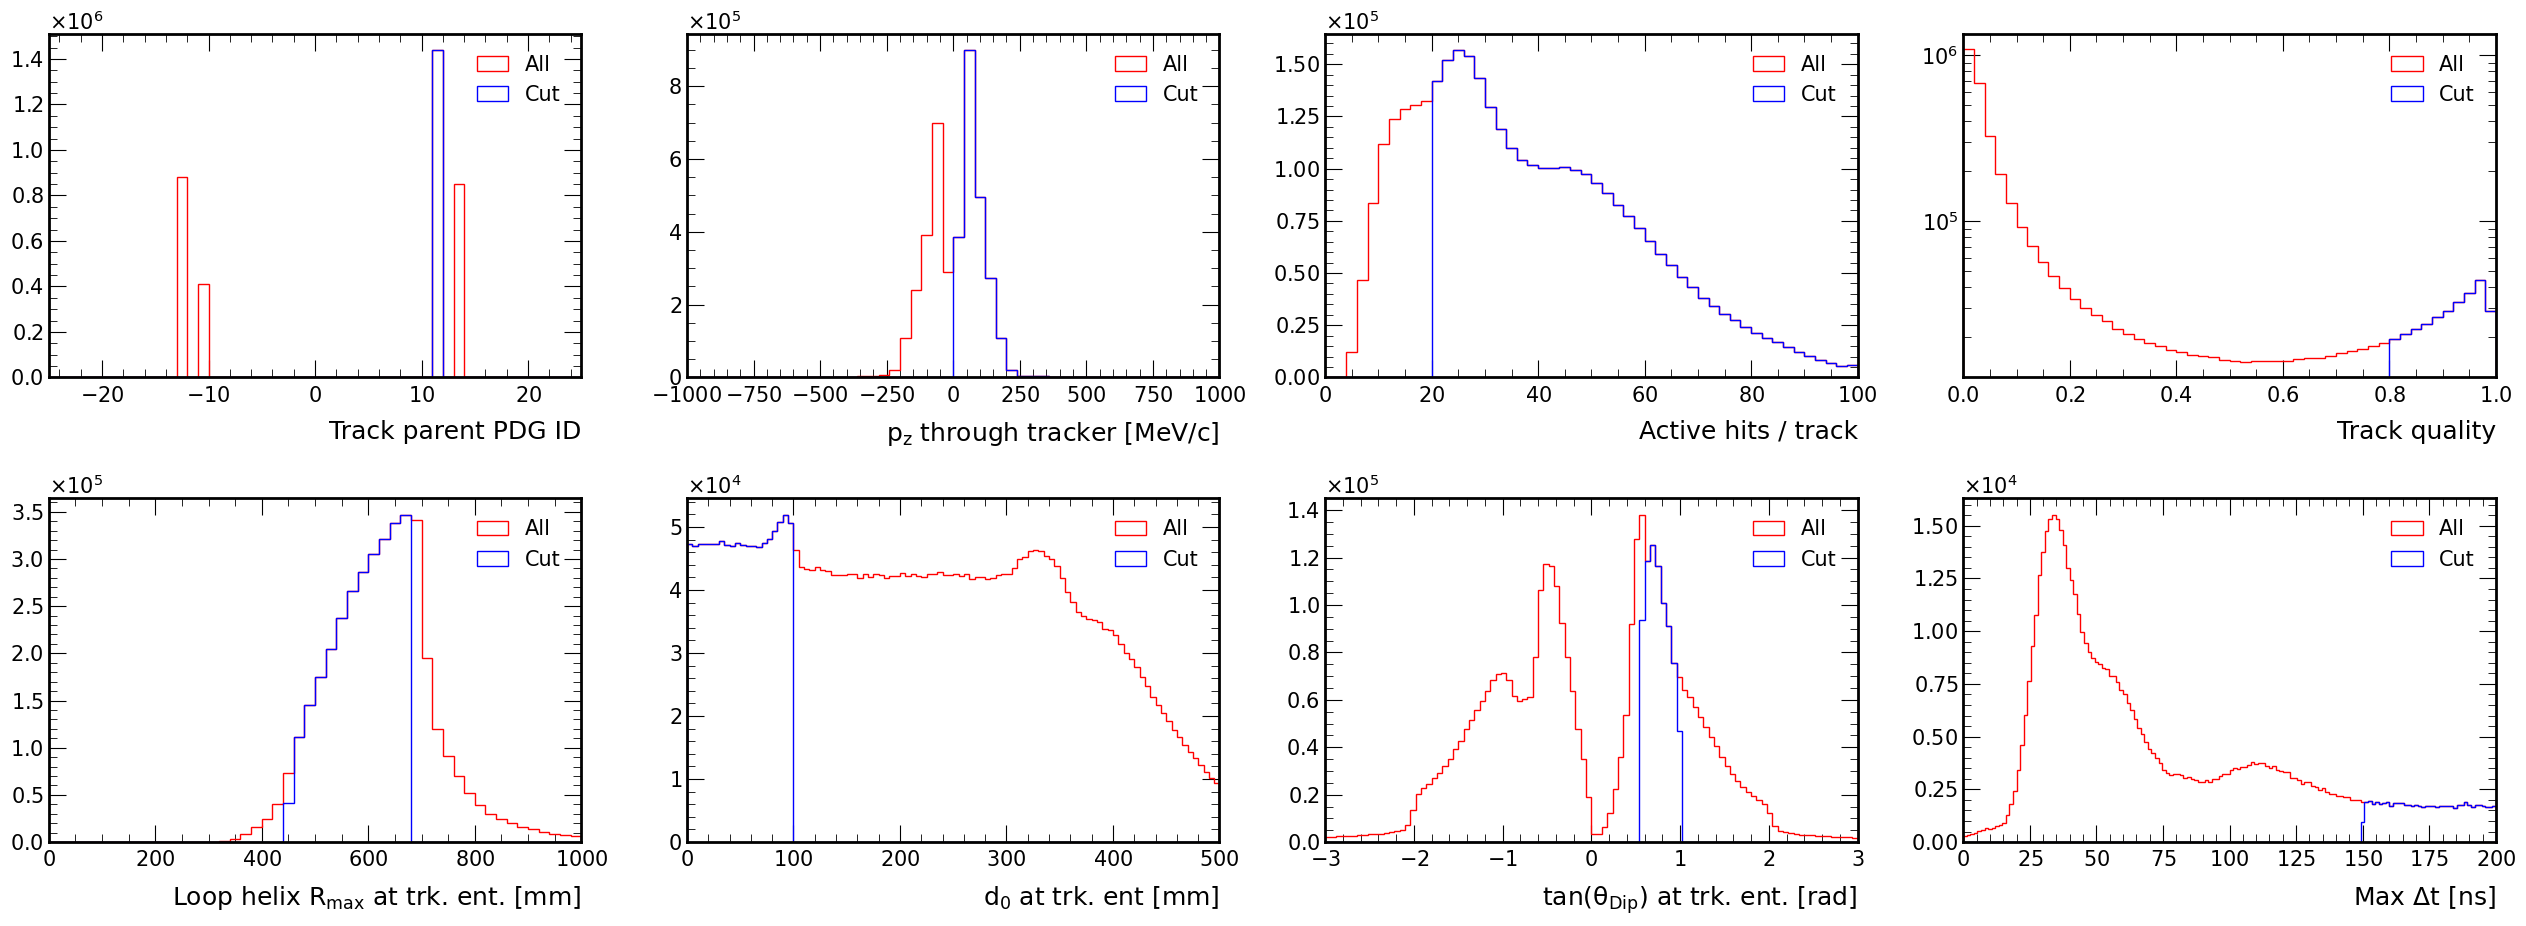

In [35]:
plotter = Plot(
    style_path="sgrant.mplstyle"
)

def plot_cut_summary(data, cuts, ax, out_path=None, on_spill=False):
    """
    Create summary plots comparing data before and after cuts.
    """

    # Flatten axes
    ax = ax.flatten()
    # Start ax index
    idx = 0 
    
    # Plot 1: PDG ID
    try:

        trkmc = data["trkmc"]
        trkmc_parents = data["trkmc"][data["is_trk_parent"]]
        trkmc_parent_electrons = data["trkmc"][data["is_trk_parent_electron"]]

        plotter.plot_1D_overlay(
            {
                # "All particles": ak.flatten(trkmc["trkmcsim"]["pdg"], axis=None),
                # "Track parents": ak.flatten(trkmc_parents["trkmcsim"]["pdg"], axis=None),
                # "$e^{-}$ track parents": ak.flatten(trkmc_parent_electrons["trkmcsim"]["pdg"], axis=None)
                "All": ak.flatten(trkmc_parents["trkmcsim"]["pdg"], axis=None),
                "Cut": ak.flatten(trkmc_parent_electrons["trkmcsim"]["pdg"], axis=None)
            },
            nbins=50, xmin=-25, xmax=25,
            xlabel="Track parent PDG ID", #title="Track parent PID",
            norm_by_area=False,
            show=False,
            ax=ax[idx]
        )

        idx += 1
    
    except Exception as e:
        print(f"Warning: Could not create PDG ID plot: {e}")

    # Plot 2: p_z
    try:
        pz = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]
        pz_before = pz[data["in_trk"]]
        pz_after = pz[data["is_downstream_in_trk"]]
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(pz_before, axis=None),
                # "$p_{z} > 0$": ak.flatten(pz_after, axis=None),
                "All": ak.flatten(pz_before, axis=None),
                "Cut": ak.flatten(pz_after, axis=None),
            },
            nbins=50, xmin=-1000, xmax=1000,
            xlabel="$p_{z}$ through tracker [MeV/c]",# title="Upstream/downstream",
            norm_by_area=False,
            show=False,
            ax=ax[idx]
        )

        idx += 1
    
    except Exception as e:
        if self.verbosity >= 1:
            print(f"Warning: Could not create hits plot: {e}")
            
    # Plot 3: Number of hits
    try:
        nhits_before = data["trk"]["trk.nactive"]
        nhits_after = data["trk"]["trk.nactive"][cuts["has_hits"]["mask"]]
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(nhits_before, axis=None),
                # "Active hits $\geq 20$": ak.flatten(nhits_after, axis=None),
                "All": ak.flatten(nhits_before, axis=None),
                "Cut": ak.flatten(nhits_after, axis=None),
            },
            nbins=50, xmin=0, xmax=100,
            xlabel="Active hits / track", #title="Hits",
            norm_by_area=False,
            show=False,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        if self.verbosity >= 1:
            print(f"Warning: Could not create hits plot: {e}")

    # Plot 4: Track quality
    try:
        trkqual_before = data["trk"]["trkqual.result"]
        trkqual_after = data["trk"]["trkqual.result"][cuts["good_trkqual"]["mask"]]
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(trkqual_before, axis=None),
                # "Quality $>0.8$": ak.flatten(trkqual_after, axis=None),
                "All": ak.flatten(trkqual_before, axis=None),
                "Cut": ak.flatten(trkqual_after, axis=None),
            },
            nbins=50, xmin=0, xmax=1,
            xlabel="Track quality", #title="Quality",
            norm_by_area=False,
            show=False,
            log_y=True,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        print(f"Warning: Could not create quality plot: {e}")

    if on_spill: 
        # Plot 5: Time at tracker entrance
        try:
          
            time_before = data["trkfit"]["trksegs"]["time"][data["at_trk_front"]]
            time_after = data["trkfit"]["trksegs"]["time"][data["within_t0_at_trkent"]]
            
            plotter.plot_1D_overlay(
                {
                    # "All": ak.flatten(time_before, axis=None),
                    # "$640 < t_{0} < 1650$ ns": ak.flatten(time_after, axis=None),
                    "All": ak.flatten(time_before, axis=None),
                    "Cut": ak.flatten(time_after, axis=None),
                },
                nbins=100, xmin=0, xmax=2000,
                xlabel="Time at trk. ent. [ns]",# title="Time",
                norm_by_area = False,
                show=False,
                ax=ax[idx]
            )
    
            idx += 1
    
        except Exception as e:
            print(f"Warning: Could not create time plot: {e}")
    
    # Plot 6: Loop helix maxr
    try:
        maxlhr = data["trkfit"]["trksegpars_lh"]["maxr"]
        maxlhr_before = maxlhr[data["at_trk_front"]]
        maxlhr_after = maxlhr[data["within_lhr_max_at_trkent"]]
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(maxlhr_before, axis=None),
                # r"$450 < R_{\text{max}} < 680$ mm": ak.flatten(maxlhr_after, axis=None),
                "All": ak.flatten(maxlhr_before, axis=None),
                "Cut": ak.flatten(maxlhr_after, axis=None),
            },
            nbins=50, xmin=0, xmax=1000,
            xlabel=r"Loop helix $R_{\text{max}}$ at trk. ent. [mm]", #title="Loop helix maximum radius",
            show=False,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        print(f"Warning: Could not create maxr plot: {e}")

    
    # Plot 7: d0
    try:
        d0 = data["trkfit"]["trksegpars_lh"]["d0"]
        d0_before = d0[data["at_trk_front"]]
        d0_after = d0[data["within_d0_at_trkent"]]
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(d0_before, axis=None),
                # "$|d_{0}| < 100$ mm": ak.flatten(d0_after, axis=None),
                "All": ak.flatten(d0_before, axis=None),
                "Cut": ak.flatten(d0_after, axis=None),
            },
            nbins=100, xmin=0, xmax=500,
            xlabel="$d_{0}$ at trk. ent [mm]", #title="Distance",
            norm_by_area = False,
            show=False,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        print(f"Warning: Could not create d0 plot: {e}")

    # Plot 8: tan(theta)
    try:

        tandip = data["trkfit"]["trksegpars_lh"]["tanDip"] # [data["at_trk_front"]]
        tandip_before = tandip[data["at_trk_front"]] 
        tandip_after = tandip[data["within_pitch_angle_at_trkent"]] 
        
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(tandip_before, axis=None),
                # r"$0.5577350 < \tan(\theta_{\text{Dip}}) < 1.0$": ak.flatten(tandip_after, axis=None),
                "All": ak.flatten(tandip_before, axis=None),
                "Cut": ak.flatten(tandip_after, axis=None),
            },
            nbins=100, xmin=-3, xmax=3,
            xlabel=r"$\tan(\theta_{\text{Dip}})$ at trk. ent. [rad]", #  title="Pitch angle",
            norm_by_area = False,
            show=False,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        print(f"Warning: Could not create tandip plot: {e}")


    # Plot 9: dt
    try:

        # Get min and max track t0 times for each event
        min_trk_time = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
        max_trk_time = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)

        # Get min and max coincidence times for each event
        min_coinc_time = ak.min(data["crv"]["crvcoincs.time"], axis=-1)
        max_coinc_time = ak.max(data["crv"]["crvcoincs.time"], axis=-1)

        # Broadcast coincidence times to match track times structure
        # This requires creating a cartesian product between coinc times and track times
        # We'll use the ak.cartesian function to do this
        
        # First, create arrays with the right structure
        coinc_info = ak.zip({
            "min_time": min_coinc_time,
            "max_time": max_coinc_time
        })
        
        trk_info = ak.zip({
            "min_time": min_trk_time,
            "max_time": max_trk_time
        })
        
        # Use cartesian product to match each coinc with each track
        matched = ak.cartesian({"coinc": coinc_info, "track": trk_info})

        dt1 = abs(matched["coinc", "max_time"] - matched["track", "min_time"])
        dt2 = abs(matched["coinc", "min_time"] - matched["track", "max_time"])

        # Plot the minimum time difference
        max_dt = ak.max(ak.concatenate([dt1, dt2], axis=-1), axis=-1)

        print(max_dt)
    
        plotter.plot_1D_overlay(
            {
                # "All": ak.flatten(tandip_before, axis=None),
                # r"$0.5577350 < \tan(\theta_{\text{Dip}}) < 1.0$": ak.flatten(tandip_after, axis=None),
                "All": ak.flatten(max_dt, axis=None),
                "Cut": ak.flatten(max_dt[max_dt >= 150], axis=None),
            },
            nbins=150, xmin=0, xmax=200,
            xlabel=r"Max $\Delta t$ [ns]", #  title="Pitch angle",
            norm_by_area = False,
            show=False,
            ax=ax[idx]
        )

        idx += 1

    except Exception as e:
        print(f"Warning: Could not create dt plot: {e}")

    plt.tight_layout()
    
    # Save if requested
    if out_path:
        print(f"\tWritten {out_path}")
        plt.savefig(out_path, dpi=300)
        
    # Add title
    # fig.suptitle("Track Selection Summary", fontsize=16)
    
    plt.show()

# Create figure with subplots
fig, ax = plt.subplots(2, 4, figsize=(6.4*4, 4.8*2))
    
plot_cut_summary(
    data, 
    cuts, 
    out_path="../img/cut_summary.png", 
    on_spill=False,
    ax=ax
)

In [30]:
# vec = Vector()
# # help(vec)

# at_trkent_all = selector.select_surface(data["trkfit"], sid=0)
# at_trkent_cut = selector.select_surface(data_cut["trkfit"], sid=0)

# mom_all = vec.get_mag(data["trkfit"]["trksegs"][at_trkent_all], "mom")
# mom_cut = vec.get_mag(data_cut["trkfit"]["trksegs"][at_trkent_cut], "mom")

# # mom_all = vec.get_mag(data["trkfit"]["trksegs"], "mom")
# # mom_cut = vec.get_mag(data_cut["trkfit"]["trksegs"], "mom")

# plotter.plot_1D_overlay(
#     {
#         "All": ak.flatten(mom_all, axis=None),
#         "CE-like": ak.flatten(mom_cut, axis=None),
#     },
#     nbins=250, xmin=0, xmax=250,
#     xlabel="Momentum at trk. ent. [MeV/c]", ylabel="Tracks / MeV/c", #  title="Pitch angle",
#     norm_by_area = False,
#     show=True,
#     log_y=True
# )

# print(mom_cut)



[pyvector] Initialised Vector with verbosity = 1
[pyselect] Returning mask for trksegs with sid = 0 and sindex = 0
[pyselect] Returning mask for trksegs with sid = 0 and sindex = 0
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
	Written ../img/h1o_mom.png


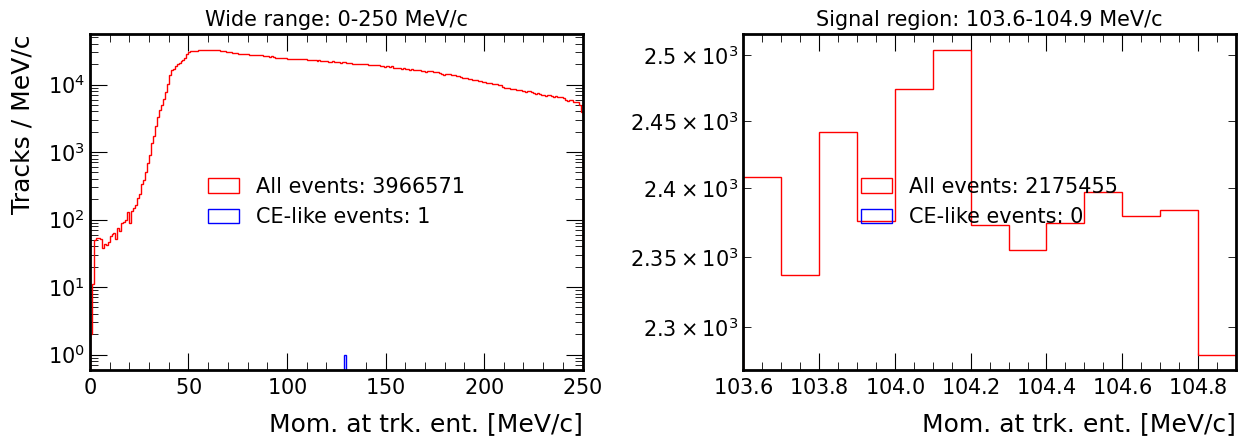

In [36]:
def plot_mom(data, data_cut, out_path=None, figsize=(6.4*2, 4.8)):
    """
    Create summary momentum plot
    """
    vec = Vector()
    
    at_trkent_all = selector.select_surface(data["trkfit"], sid=0)
    at_trkent_cut = selector.select_surface(data_cut["trkfit"], sid=0)
    
    mom_all = vec.get_mag(data["trkfit"]["trksegs"][at_trkent_all], "mom")
    mom_cut = vec.get_mag(data_cut["trkfit"]["trksegs"][at_trkent_cut], "mom")

    mom_all = ak.flatten(mom_all, axis=None)
    mom_cut = ak.flatten(mom_cut, axis=None)
    
    # Create figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()



    # Plot 1: full momentum range
    try:
        
        plotter.plot_1D_overlay(
            {
                f"All events: {len(mom_all)}": mom_all,
                f"CE-like events: {len(mom_cut)}": mom_cut,
            },
            nbins=250, xmin=0, xmax=250,
            xlabel="Mom. at trk. ent. [MeV/c]", ylabel="Tracks / MeV/c", 
            log_y=True,
            show=False,
            ax=ax[0],
            leg_pos="center",
            title="Wide range: 0-250 MeV/c"
        )

    except Exception as e:
        print(f"Warning: Could not create momentum plot: {e}")

    # Plot 2: signal region
    try:
        
        plotter.plot_1D_overlay(
            {
                f"All events: {len(mom_all[mom_all >= 103.6])}": mom_all,
                f"CE-like events: {len(mom_cut[mom_cut <= 104.9])}": mom_cut,
            },
            nbins=13, xmin=103.6, xmax=104.9, 
            xlabel="Mom. at trk. ent. [MeV/c]", #ylabel="Tracks / MeV/c", 
            log_y=True,
            show=False,
            ax=ax[1],
            title="Signal region: 103.6-104.9 MeV/c",
            leg_pos="center",
        )

    except Exception as e:
        print(f"Warning: Could not create signal region momentum plot: {e}")


    plt.tight_layout()
    
    # Save if requested
    if out_path:
        print(f"\tWritten {out_path}")
        plt.savefig(out_path, dpi=300)
        
    
    plt.show()

plot_mom(
    data,
    data_cut,
    "../img/h1o_mom.png"
)


In [55]:
printer.print_n_events(data_cut)


[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 184276
evt.run: 1202
evt.subrun: 50440
in_trk: [[False, False, False, False, False, False, True, False, False], ..., [...]]
at_trk_front: [[False, False, False, False, False, False, True, False, False], ..., [...]]
is_trk_parent: [[True, False, False, False, False, False, False], ..., [True, ..., False]]
is_trk_parent_electron: [[True, False, False, False, False, False, False], ..., [True, ..., False]]
is_electron: [True, True, True, True, True, True, True, True]
is_downstream_in_trk: [[False, False, False, False, False, False, True, False, False], ..., [...]]
within_lhr_max_at_trkent: [[False, False, False, False, False, False, True, False, False], ..., [...]]
within_d0_at_trkent: [[False, False, False, False, False, False, True, False, False], ..., [...]]
within_pitch_angle_at_trkent: [[False, False, False, False, False, False, True, False, False], 